In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
import re
import spacy

class TransformerEncoderModel(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=2, num_layers=2, dim_feedforward=128, num_classes=3):
        super(TransformerEncoderModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, activation='gelu'),
            num_layers
        )
        self.fc = nn.Linear(d_model, num_classes)  # Output layer for sentiment classification

    def forward(self, src):
        src_emb = self.positional_encoding(self.embedding(src))
        enc_output = self.encoder(src_emb)
        pooled_output = enc_output.mean(dim=1)  # Simple mean pooling for classification
        return self.fc(pooled_output)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add the positional encoding to the input
        # Make sure the positional encoding is on the correct device
        return x + self.pe[:, :x.size(1), :].to(x.device)


In [ ]:
import pandas as pd
train_data = '/content/train.csv'
test_data = '/content/test.csv'

train_df = pd.read_csv(train_data,encoding='latin1')
test_df = pd.read_csv(test_data,encoding='latin1')
df = pd.concat([train_df, test_df], ignore_index = True)

df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [ ]:
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
df.isna().sum()

,0
text,1282
sentiment,1281


In [ ]:
df = df.dropna()
df.shape

(31014, 2)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [ ]:
import re
import torch
from collections import Counter
def tokenize(text):
    return [word for word in re.findall(r'\b\w+\b', text.lower())] # Keeps only words

tokenized_texts = [tokenize(text) for text in df['text']]

# Count Word Frequencies
word_counts = Counter(word for tokens in tokenized_texts for word in tokens)

# Assign an Index to Each Word
vocab = {'<pad>': 0, '<unk>': 1}  # Start with special tokens
for idx, (word, _) in enumerate(word_counts.items(), start=2):
    vocab[word] = idx  # Assign an index

# Convert Text to Index Sequences
def text_to_tensor(text, max_len=50):
    tokens = tokenize(text)
    token_ids = [vocab.get(token, vocab['<unk>']) for token in tokens]  # Use <unk> for unknown words
    return torch.tensor(token_ids[:max_len])  # Truncate if too long

In [ ]:
# Encode Sentiments
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])  # Convert labels to integers
df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [ ]:
X = [text_to_tensor(text) for text in df['text']]
y = torch.tensor(df['sentiment'].values, dtype=torch.int64)
texts = df['text'].tolist()

# Pad Sequences
X_padded = pad_sequence(X, batch_first=True, padding_value=vocab['<pad>'])

In [ ]:
# Split Train & Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, texts_train, texts_test = train_test_split(
    X_padded, y, texts, test_size=0.1
)

class SentimentDataset(Dataset):
    def __init__(self, X, y, texts):
        self.X = X
        self.y = y
        self.texts = texts

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.texts[idx]

In [ ]:
# Create Train & Test Datasets
train_dataset = SentimentDataset(X_train, y_train, texts_train)
test_dataset = SentimentDataset(X_test, y_test, texts_test)

# Collate Function to Handle Texts
def collate_fn(batch):
    inputs, labels, texts = zip(*batch)
    return torch.stack(inputs), torch.tensor(labels), list(texts)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
count=0
for batch in test_loader:
    count+=len(batch[0])
print(count)

3102


In [ ]:
test_loader.dataset[0]

(tensor([    2,   583,    38,   719,   724, 28158,    49,    22,    80,    90,
           209,    23, 25800,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 tensor(2),
 ' i wish we had sun lollies for me to get addicted  what flavour?')

In [ ]:
# Training Function
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch,_ in train_loader:
            X_batch, y_batch,_ = X_batch.to(device), y_batch.to(device),_
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch,_ in test_loader:
            X_batch, y_batch,_ = X_batch.to(device), y_batch.to(device),_
            outputs = model(X_batch)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
    print(f"Test Accuracy: {correct / total:.4f}")

In [ ]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Initialization
vocab_size = len(vocab)
num_classes = len(label_encoder.classes_)
model = TransformerEncoderModel(vocab_size, num_classes=num_classes).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train & Evaluate
train_model(model, train_loader, criterion, optimizer, epochs=20)

Epoch 1/20, Loss: 1.0363126012058193
Epoch 2/20, Loss: 0.9080839056739283
Epoch 3/20, Loss: 0.8029131663350851
Epoch 4/20, Loss: 0.7080887949002431
Epoch 5/20, Loss: 0.6358777198424181
Epoch 6/20, Loss: 0.5738731479999809
Epoch 7/20, Loss: 0.52128823973742
Epoch 8/20, Loss: 0.476640439712851
Epoch 9/20, Loss: 0.4394345186727563
Epoch 10/20, Loss: 0.399013703844733
Epoch 11/20, Loss: 0.3664517813839044
Epoch 12/20, Loss: 0.3417078244573472
Epoch 13/20, Loss: 0.3163584398270029
Epoch 14/20, Loss: 0.2971720309738168
Epoch 15/20, Loss: 0.27481394034531925
Epoch 16/20, Loss: 0.25683192652730186
Epoch 17/20, Loss: 0.23939695078260848
Epoch 18/20, Loss: 0.22573480776426855
Epoch 19/20, Loss: 0.2154455646266574
Epoch 20/20, Loss: 0.20101760389264098


In [ ]:
evaluate_model(model, test_loader)

Test Accuracy: 0.6125


In [ ]:
import pandas as pd
import torch

label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}

model.eval()
predictions = []
actual_labels = []
texts = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels, text_samples = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Shape: (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1)  # Get predicted class index

        predictions.extend([label_mapping[p] for p in preds.cpu().numpy()])
        actual_labels.extend([label_mapping[l] for l in labels.cpu().numpy()])
        texts.extend(text_samples)

df_results = pd.DataFrame({'Text': texts, 'Actual': actual_labels, 'Predicted': predictions})
print(df_results)


                                                   Text    Actual Predicted
0      i wish we had sun lollies for me to get addic...  Positive  Negative
1     does not feel like babysitting. i want to go t...  Negative  Negative
2     Just finished studying for Abnormal Psychology...  Negative   Neutral
3     About to have dinner and then an evening of pl...   Neutral   Neutral
4     AHHHHHHHH omg Pridelines got talent is giving ...  Negative  Negative
...                                                 ...       ...       ...
3097   alarm watch + pill name display for functioni...   Neutral  Negative
3098                          are you having a bad day?   Neutral  Negative
3099             Yes - noticed that after the retweet..   Neutral   Neutral
3100            ha! you`re right...I know you`re right.  Positive   Neutral
3101   were you roaming?? Same thing happen to me  s...   Neutral   Neutral

[3102 rows x 3 columns]


In [ ]:
!pip install datasets

In [ ]:
train_df = pd.read_csv(train_data,encoding='latin1')
test_df = pd.read_csv(test_data,encoding='latin1')
df = pd.concat([train_df, test_df], ignore_index = True)

df.head()
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
df = df.dropna()
df.shape

(31014, 2)

In [ ]:
import pandas as pd
import torch
from transformers import pipeline
from datasets import Dataset

# Convert DataFrame to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)

# Initialize sentiment pipelines
pipeline_gpu = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0  # GPU 0
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [ ]:

# Batch prediction functions
def predict_batch_gpu0(batch):
    predictions = pipeline_gpu(batch['text'], batch_size=8)
    return {'ROBERTA_sentiment': [pred['label'].lower() for pred in predictions]}

# Apply batch processing
dataset = hf_dataset.map(predict_batch_gpu0, batched=True)

Map:   0%|          | 0/31014 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
dataset

Dataset({
    features: ['text', 'sentiment', '__index_level_0__', 'ROBERTA_sentiment'],
    num_rows: 31014
})

In [ ]:
# Combine the results and convert back to Pandas DataFrame
hf_dataset = Dataset.from_dict({
    key: dataset[key]
    for key in dataset.features
})
df = hf_dataset.to_pandas()
df.head()

,text,sentiment,__index_level_0__,ROBERTA_sentiment
0,"I`d have responded, if I were going",neutral,0,label_1
1,Sooo SAD I will miss you here in San Diego!!!,negative,1,label_0
2,my boss is bullying me...,negative,2,label_0
3,what interview! leave me alone,negative,3,label_0
4,"Sons of ****, why couldn`t they put them on t...",negative,4,label_0


In [ ]:
# Label mapping
label_mapping = {
    "label_0": "negative",
    "label_1": "neutral",
    "label_2": "positive"
}
df['ROBERTA_sentiment'] = df['ROBERTA_sentiment'].map(label_mapping)
df = df[['text', 'sentiment', 'ROBERTA_sentiment']]

score = df['sentiment'] == df['ROBERTA_sentiment']
print(score.value_counts()/len(score))

True     0.720932
False    0.279068
Name: count, dtype: float64


In [ ]:
df['ROBERTA_sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

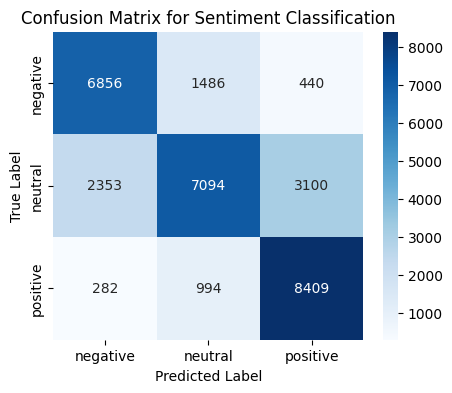

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# True sentiment labels
true_sentiments = df['sentiment']

# Predicted sentiment labels (ROBERTA model)
predicted_sentiments = df['ROBERTA_sentiment']

# Generate confusion matrix
labels = ["negative", "neutral", "positive"]
cm = confusion_matrix(true_sentiments, predicted_sentiments, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Sentiment Classification")
plt.show()